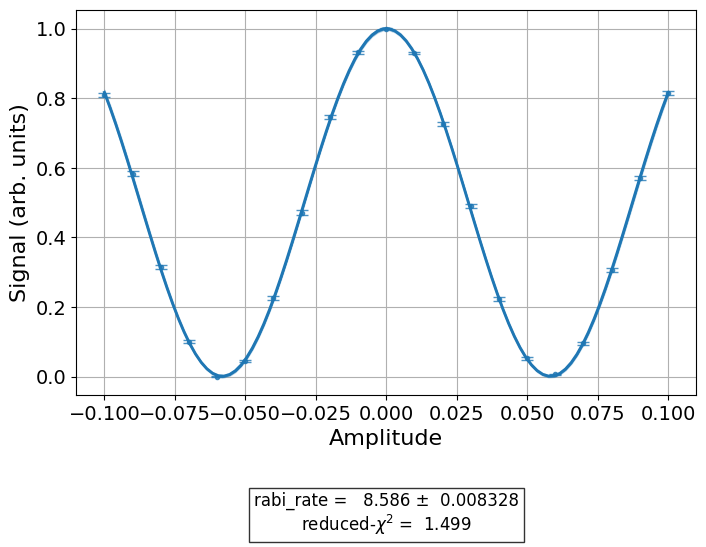

In [1]:
import numpy as np

from qiskit import pulse
from qiskit.circuit import Parameter

from qiskit_experiments.test.pulse_backend import SingleTransmonTestBackend
from qiskit_experiments.data_processing import DataProcessor, nodes
from qiskit_experiments.library import Rabi

with pulse.build() as sched:
    pulse.play(
        pulse.Gaussian(160, Parameter("amp"), sigma=40),
        pulse.DriveChannel(0)
    )

seed = 100
backend = SingleTransmonTestBackend(seed=seed)

rabi = Rabi(
    physical_qubits=(0,),
    backend=backend,
    schedule=sched,
    amplitudes=np.linspace(-0.1, 0.1, 21),
)

rabi_data = rabi.run().block_for_results()
rabi_data.figure(0)

In [2]:
%matplotlib inline

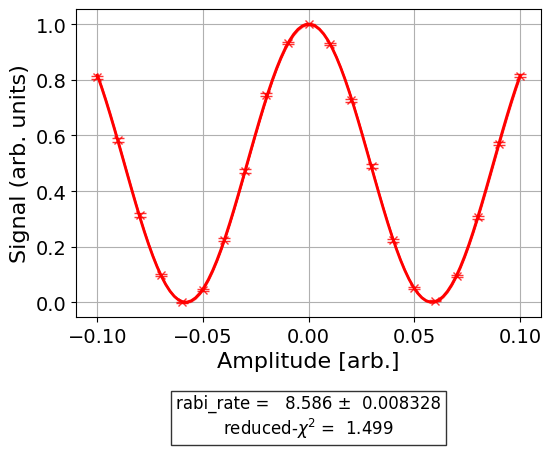

In [3]:
# Retrieve the plotter from the analysis instance
plotter = rabi.analysis.plotter

# Change the x-axis unit values
plotter.set_figure_options(
    xval_unit="arb.",
    xval_unit_scale=False   # Don't scale the unit with SI prefixes
)

# Change the color and symbol for the cosine
plotter.figure_options.series_params.update(
    {"cos": {"symbol": "x", "color": "r"}}
)

# Set figsize directly so we don't overwrite the entire style
plotter.options.style["figsize"] = (6,4)

# Generate the new figure
plotter.figure()

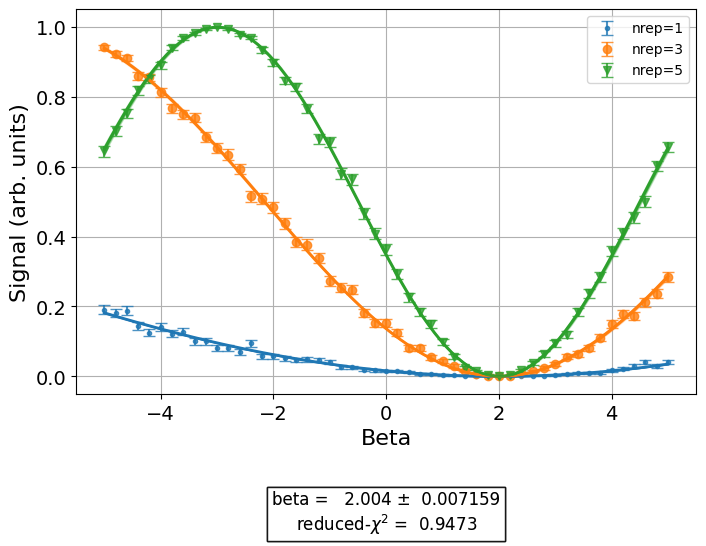

In [4]:
from qiskit_experiments.library import RoughDrag
from qiskit_experiments.visualization import PlotStyle
from qiskit_experiments.test.mock_iq_helpers import MockIQDragHelper as DragHelper
from qiskit_experiments.test.mock_iq_backend import MockIQBackend
from qiskit.circuit import Parameter
from qiskit import pulse
from qiskit.pulse import DriveChannel, Drag


beta = Parameter("beta")
with pulse.build(name="xp") as xp:
    pulse.play(pulse.Drag(64, 0.66, 16, beta), pulse.DriveChannel(0))

drag_experiment_helper = DragHelper(gate_name="Drag(xp)")
backend = MockIQBackend(drag_experiment_helper, rng_seed=seed)

drag = RoughDrag((0,), xp, backend=backend)

drag_data = drag.run().block_for_results()
drag_data.figure(0)

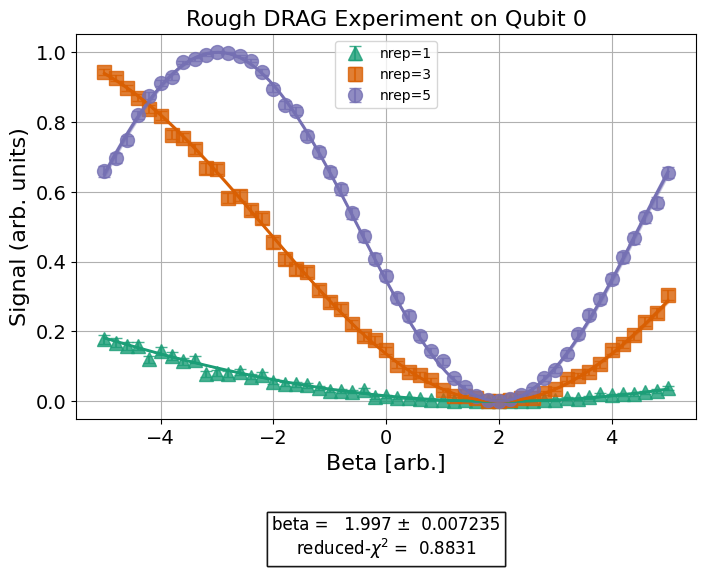

In [5]:
drag = RoughDrag((0,), xp, backend=backend)

# Set plotter options
plotter = drag.analysis.plotter

# Update series parameters
plotter.figure_options.series_params.update(
    {
        "nrep=1": {
            "color": (27/255, 158/255, 119/255),
            "symbol": "^",
        },
        "nrep=3": {
            "color": (217/255, 95/255, 2/255),
            "symbol": "s",
        },
        "nrep=5": {
            "color": (117/255, 112/255, 179/255),
            "symbol": "o",
        },
    }
)

# Set figure options
plotter.set_figure_options(
    xval_unit="arb.",
    xval_unit_scale=False,
    figure_title="Rough DRAG Experiment on Qubit 0",
)

# Set style parameters
plotter.options.style["symbol_size"] = 10
plotter.options.style["legend_loc"] = "upper center"

drag_data = drag.run().block_for_results()
drag_data.figure(0)

In [ ]:
with pulse.build(name="xp") as xp:
    pulse.play(Drag(duration=160, amp=0.208519, sigma=40, beta=beta), DriveChannel(0))

x_plus = xp
drag = RoughDrag(1, x_plus)

expdata = drag.run(backend)

from qiskit_experiments.framework import BaseAnalysis, Options
from qiskit_experiments.visualization import (
    BasePlotter,
    IQPlotter,
    MplDrawer,
    PlotStyle,
)

class MYIQAnalysis(BaseAnalysis):
    @classmethod
    def _default_options(cls) -> Options:
        options = super()._default_options()
        # We create the plotter and create an option for it.
        options.plotter = IQPlotter(MplDrawer())
        options.plotter.set_figure_options(
            xlabel="In-phase",
            ylabel="Quadrature",
            figure_title="My IQ Analysis Figure",
            series_params={
                "0": {"label": "|0>"},
                "1": {"label": "|1>"},
                "2": {"label": "|2>"},
            },
        )
        return options

    @property
    def plotter(self) -> BasePlotter:
        return self.options.plotter

    def _run_analysis(self, experiment_data):
        data = experiment_data.data()
        analysis_results = []
        for datum in data:
                # Analysis code
                analysis_results.append(self._analysis_result(datum))

                # Plotting code
                series_name = datum["metadata"]["name"]
                points = datum["memory"]
                centroid = np.mean(points, axis=0)
                self.plotter.set_series_data(
                    series_name,
                    points=points,
                    centroid=centroid,
                )

        # Add discriminator to IQPlotter
        discriminator = self._train_discriminator(data)
        self.plotter.set_supplementary_data(discriminator=discriminator)

        return analysis_results, [self.plotter.figure()]